In [1]:
from google.colab import files
uploaded = files.upload()

Saving data_640_validated.csv to data_640_validated.csv


# Model Prediction

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna

# Load the dataset
data_path = 'data_640_validated.csv'
data = pd.read_csv(data_path, encoding='ISO-8859-1')

# Map and bin target variable
mapping = {
    "No self-isolation/social distancing": 0,
    "1 day": 1,
    "3 days": 3,
    "4 days": 4,
    "5 days": 5,
    "6 days": 6,
    "7 days": 7,
    "More than a week": 11,
    "More than 2 weeks": 18,
    "More than 3 weeks": 26,
    "More than a month": 32
}
data['B2_numeric'] = data['B2'].map(mapping)
data = data.dropna(subset=['B2_numeric'])

bins = [0, 7, 14, 32]
labels = ['Short', 'Medium', 'Long']
data['B2_category'] = pd.cut(data['B2_numeric'], bins=bins, labels=labels, include_lowest=True)

behavioral_columns = [col for col in data.columns if col.startswith('E')]
X = data[behavioral_columns]
y = data['B2_category']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Encode target variable
y_resampled_encoded = pd.factorize(y_resampled)[0]

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_encoded, test_size=0.2, random_state=42, stratify=y_resampled_encoded
)

# Define cross-validation and objective function
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'auto_class_weights': 'Balanced',
        'random_seed': 42,
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_list = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

        model = CatBoostClassifier(**param, verbose=0)
        model.fit(X_train_cv, y_train_cv)
        preds = model.predict(X_val_cv)
        accuracy_list.append(accuracy_score(y_val_cv, preds))

    return np.mean(accuracy_list)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Parameters:", best_params)

# Train final model with best parameters
final_model = CatBoostClassifier(**best_params, random_seed=42, auto_class_weights='Balanced', verbose=100)
final_model.fit(X_train, y_train)

# Evaluate model on test set
y_test_pred = final_model.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

# Evaluate model on original dataset for comparison
y_original_pred = final_model.predict(X)
print("Original Dataset Performance:")
print(classification_report(pd.factorize(y)[0], y_original_pred))

[I 2024-12-10 15:24:23,717] A new study created in memory with name: no-name-0cd8dcbc-b0aa-4c7f-b7bf-c5f541808cc7
[I 2024-12-10 15:25:22,603] Trial 0 finished with value: 0.8962675802380093 and parameters: {'iterations': 1547, 'depth': 10, 'learning_rate': 0.0822477290958233, 'l2_leaf_reg': 6.483215050932714, 'bagging_temperature': 0.23416187596988491}. Best is trial 0 with value: 0.8962675802380093.
[I 2024-12-10 15:25:44,228] Trial 1 finished with value: 0.9081680490443563 and parameters: {'iterations': 1993, 'depth': 7, 'learning_rate': 0.023016614850363673, 'l2_leaf_reg': 1.0538709474578285, 'bagging_temperature': 0.6194191353317419}. Best is trial 1 with value: 0.9081680490443563.
[I 2024-12-10 15:25:48,138] Trial 2 finished with value: 0.8341795888928958 and parameters: {'iterations': 513, 'depth': 6, 'learning_rate': 0.014585518920516334, 'l2_leaf_reg': 6.614928421974129, 'bagging_temperature': 0.8825535583789893}. Best is trial 1 with value: 0.9081680490443563.
[I 2024-12-10 15

Best Parameters: {'iterations': 1821, 'depth': 9, 'learning_rate': 0.1458516900363221, 'l2_leaf_reg': 1.0164566231035457, 'bagging_temperature': 0.7989708951348267}
0:	learn: 0.9832623	total: 4.18ms	remaining: 7.61s
100:	learn: 0.0442591	total: 436ms	remaining: 7.43s
200:	learn: 0.0156639	total: 863ms	remaining: 6.95s
300:	learn: 0.0086483	total: 1.61s	remaining: 8.14s
400:	learn: 0.0058835	total: 2.65s	remaining: 9.38s
500:	learn: 0.0043661	total: 3.68s	remaining: 9.69s
600:	learn: 0.0034868	total: 4.34s	remaining: 8.81s
700:	learn: 0.0028845	total: 4.77s	remaining: 7.62s
800:	learn: 0.0024535	total: 5.18s	remaining: 6.6s
900:	learn: 0.0021236	total: 5.61s	remaining: 5.73s
1000:	learn: 0.0018761	total: 6.03s	remaining: 4.94s
1100:	learn: 0.0016772	total: 6.45s	remaining: 4.22s
1200:	learn: 0.0015201	total: 6.86s	remaining: 3.54s
1300:	learn: 0.0013903	total: 7.27s	remaining: 2.9s
1400:	learn: 0.0012778	total: 7.7s	remaining: 2.31s
1500:	learn: 0.0011839	total: 8.11s	remaining: 1.73s
1

# Testing on Unseen data

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna

# Load the dataset
data_path = 'data_640_validated.csv'
data = pd.read_csv(data_path, encoding='ISO-8859-1')

# Map and bin target variable
mapping = {
    "No self-isolation/social distancing": 0,
    "1 day": 1,
    "3 days": 3,
    "4 days": 4,
    "5 days": 5,
    "6 days": 6,
    "7 days": 7,
    "More than a week": 11,
    "More than 2 weeks": 18,
    "More than 3 weeks": 26,
    "More than a month": 32
}
data['B2_numeric'] = data['B2'].map(mapping)
data = data.dropna(subset=['B2_numeric'])

bins = [0, 7, 14, 32]
labels = ['Short', 'Medium', 'Long']
data['B2_category'] = pd.cut(data['B2_numeric'], bins=bins, labels=labels, include_lowest=True)

# Select behavioral columns and target
behavioral_columns = [col for col in data.columns if col.startswith('E')]
X = data[behavioral_columns]
y = data['B2_category']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Encode target variable
y_resampled_encoded = pd.factorize(y_resampled)[0]

# Split data into train+validation and test (unknown) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_resampled, y_resampled_encoded, test_size=0.2, random_state=42, stratify=y_resampled_encoded
)

# Further split train+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 * 0.8 = 0.2 of total data for validation

# Define cross-validation and objective function for hyperparameter tuning
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'auto_class_weights': 'Balanced',
        'random_seed': 42,
    }

    # Train and validate the model
    model = CatBoostClassifier(**param, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    val_preds = model.predict(X_val)
    return accuracy_score(y_val, val_preds)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Parameters:", best_params)

# Train final model on training + validation set
final_model = CatBoostClassifier(**best_params, random_seed=42, auto_class_weights='Balanced', verbose=100)
final_model.fit(X_train_val, y_train_val)

# Evaluate model on test (unknown) set
y_test_pred = final_model.predict(X_test)
print("Test (Unknown) Set Performance:")
print(classification_report(y_test, y_test_pred))

# Evaluate model on validation set
y_val_pred = final_model.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Evaluate model on original dataset for comparison
y_original_pred = final_model.predict(X)
print("Original Dataset Performance:")
print(classification_report(pd.factorize(y)[0], y_original_pred))

[I 2024-12-10 15:48:26,851] A new study created in memory with name: no-name-c7bdccf2-3d1b-4518-a454-22296d143f8b
[I 2024-12-10 15:48:31,157] Trial 0 finished with value: 0.9115646258503401 and parameters: {'iterations': 1358, 'depth': 6, 'learning_rate': 0.04153504360212679, 'l2_leaf_reg': 2.971410632678498, 'bagging_temperature': 0.3813373916568821}. Best is trial 0 with value: 0.9115646258503401.
[I 2024-12-10 15:48:36,449] Trial 1 finished with value: 0.9115646258503401 and parameters: {'iterations': 1239, 'depth': 8, 'learning_rate': 0.10802332004305665, 'l2_leaf_reg': 3.7608169592351555, 'bagging_temperature': 0.9298828955995531}. Best is trial 0 with value: 0.9115646258503401.
[I 2024-12-10 15:48:38,074] Trial 2 finished with value: 0.9013605442176871 and parameters: {'iterations': 706, 'depth': 7, 'learning_rate': 0.06251005054854544, 'l2_leaf_reg': 8.85352317567693, 'bagging_temperature': 0.4017374691539871}. Best is trial 0 with value: 0.9115646258503401.
[I 2024-12-10 15:48:

Best Parameters: {'iterations': 1009, 'depth': 7, 'learning_rate': 0.050220274728249664, 'l2_leaf_reg': 2.256158814623272, 'bagging_temperature': 0.7494197680592786}
0:	learn: 1.0645899	total: 1.93ms	remaining: 1.94s
100:	learn: 0.3081542	total: 218ms	remaining: 1.96s
200:	learn: 0.1710782	total: 409ms	remaining: 1.64s
300:	learn: 0.1081166	total: 601ms	remaining: 1.41s
400:	learn: 0.0748595	total: 780ms	remaining: 1.18s
500:	learn: 0.0564354	total: 958ms	remaining: 972ms
600:	learn: 0.0440098	total: 1.17s	remaining: 794ms
700:	learn: 0.0354588	total: 1.35s	remaining: 595ms
800:	learn: 0.0291773	total: 1.53s	remaining: 399ms
900:	learn: 0.0247413	total: 1.72s	remaining: 207ms
1000:	learn: 0.0212849	total: 1.91s	remaining: 15.2ms
1008:	learn: 0.0210363	total: 1.92s	remaining: 0us
Test (Unknown) Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        98
           1       0.93      0.93      0.93        98
           2   

# Graphs

<ipython-input-12-bbfb13d1a5bb>:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  averages_df = pd.concat([averages_df, pd.DataFrame([means])], ignore_index=True)


Average values of top features for specific durations:
                               Duration       E19       E12       E23  \
0   No self-isolation/social distancing  2.477477  3.297297  2.351351   
1                                 1 day  2.000000  2.750000  2.250000   
2                                3 days  2.000000  2.000000  2.000000   
3                                4 days  2.000000  2.333333  2.000000   
4                                5 days  4.000000  4.000000  4.000000   
5                                6 days  2.000000  3.500000  3.000000   
6                                7 days  2.857143  3.285714  2.857143   
7                      More than a week  3.250000  2.900000  3.050000   
8                     More than 2 weeks  2.809524  2.952381  2.952381   
9                     More than 3 weeks  2.955556  3.111111  2.911111   
10                    More than a month  2.774194  3.655087  2.250620   

          E7        E1  
0   3.837838  2.954955  
1   4.250000  3.25

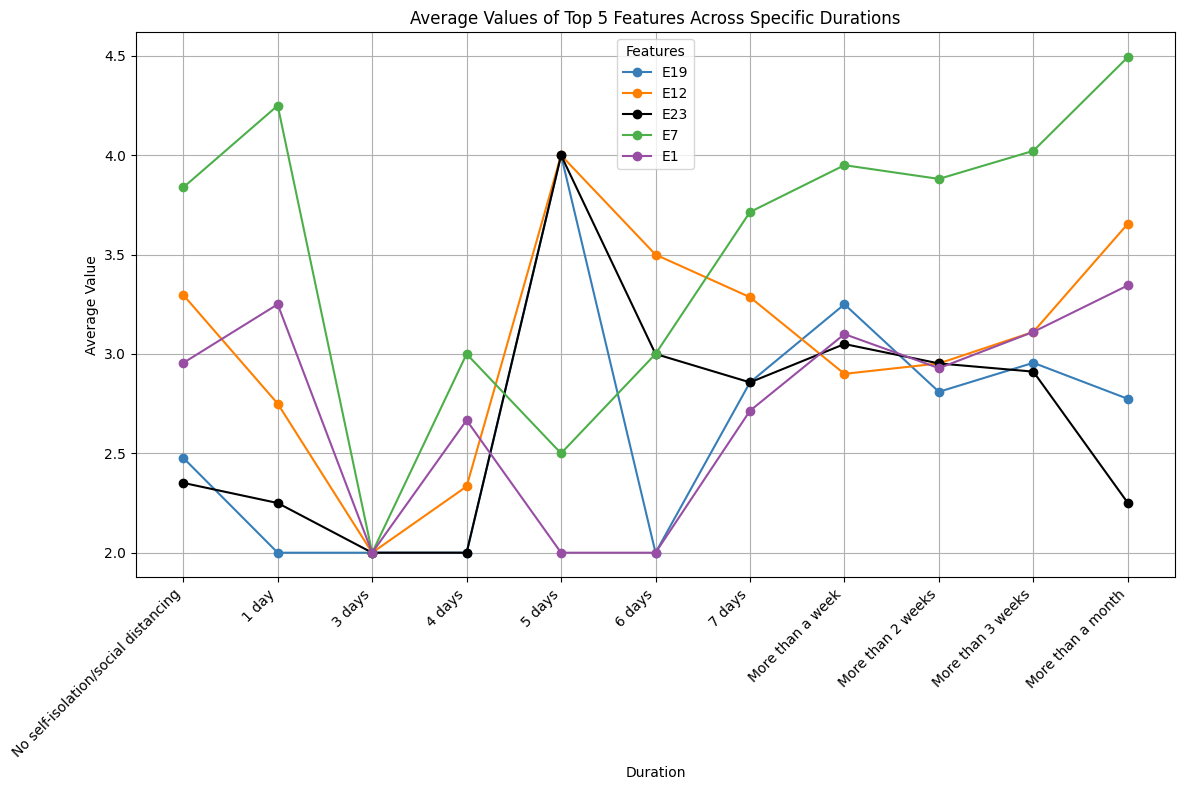

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

# Load the dataset
data_path = 'data_640_validated.csv'
data = pd.read_csv(data_path, encoding='ISO-8859-1')

# Map and bin target variable
mapping = {
    "No self-isolation/social distancing": 0,
    "1 day": 1,
    "3 days": 3,
    "4 days": 4,
    "5 days": 5,
    "6 days": 6,
    "7 days": 7,
    "More than a week": 11,
    "More than 2 weeks": 18,
    "More than 3 weeks": 26,
    "More than a month": 32
}
data['B2_numeric'] = data['B2'].map(mapping)
data = data.dropna(subset=['B2_numeric'])

# Define bins and corresponding labels
bins = [0, 7, 14, 32]
labels = ['0-7 days (Up to 1 week)', '8-14 days (1-2 weeks)', '15-32 days (Over 2 weeks up to 1 month)']
data['B2_category'] = pd.cut(data['B2_numeric'], bins=bins, labels=labels, include_lowest=True)

# Select behavioral columns
behavioral_columns = [col for col in data.columns if col.startswith('E')]
X = data[behavioral_columns]
y = data['B2_category']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Encode target variable
y_resampled_encoded = pd.factorize(y_resampled)[0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_encoded, test_size=0.2, random_state=42, stratify=y_resampled_encoded
)

# Train a CatBoostClassifier to identify top features
model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.05,
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=0
)
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 5 features for analysis
top_5_features = feature_importance_df.head(5)['Feature']

# Calculate average values of top features for each specific duration
averages_df = pd.DataFrame(columns=['Duration', *top_5_features])

for duration_label, duration_value in mapping.items():
    filtered_data = data[data['B2_numeric'] == duration_value]
    means = filtered_data[top_5_features].mean().to_dict()
    means['Duration'] = duration_label
    averages_df = pd.concat([averages_df, pd.DataFrame([means])], ignore_index=True)

# Display the averages for specific durations
print("Average values of top features for specific durations:")
print(averages_df)

# Plot the average values of the top 5 features for specific durations
plt.figure(figsize=(12, 8))

# Colorblind-friendly colors
colorblind_friendly_colors = ['#377eb8', '#ff7f00', '#000000', '#4daf4a', '#984ea3']  # Blue, Orange, Black, Green, Magenta

# Plot each feature with a unique color
for i, feature in enumerate(top_5_features):
    plt.plot(averages_df['Duration'], averages_df[feature], marker='o', label=feature, color=colorblind_friendly_colors[i])

# Add labels, title, and legend
plt.xticks(rotation=45, ha='right')
plt.xlabel('Duration')
plt.ylabel('Average Value')
plt.title('Average Values of Top 5 Features Across Specific Durations')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Features")
plt.show()